In [1]:
import numpy as np
import math as m
import sklearn as sk
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy as cp
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer

**1. Génération des données synthétiques avec make_moons de sklearn**

In [2]:
# On peut modifier noise pour avoir des nuages de points plus ou moins séparables
X,y = make_moons(n_samples=2000, shuffle=True, noise =0.05)
# decoupage en train et test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1000, train_size=1000, shuffle=True)

**représentation des données sur un graphique**

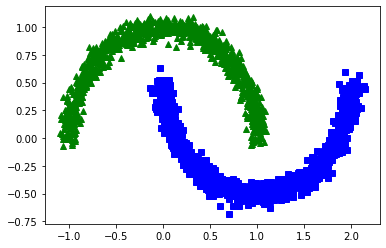

In [3]:
plt.plot(X[:, 0][y==1], X[:, 1][y==1],'bs')
plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'g^')
plt.show()

**2. Implémentatation de différents classifieurs : KNN, Random forest et SVM**

In [4]:
# fonction pour mesurer l'accuracy de notre classifieur
def accuracy(y,pred):
    n=0
    for i in range(len(y)):
        if y[i]==pred[i]:
            n+=1
    return n/len(y)

In [5]:
# KNN 
# On peut modifier le nombre de voisins pour voir l'effet sur l'accuracy
neigh = KNeighborsClassifier(n_neighbors=200)
# On entraine le classifieur
neigh.fit(X_train, y_train)
# On prédit les valeurs sur le jeu de test
pred = neigh.predict(X_test)
# On mesure l'accuracy
accuracy(y_test,pred)

0.989

In [6]:
# random forest
# On peut modifier le nombre d'arbres pour voir l'effet sur l'accuracy
clf = RandomForestClassifier(n_estimators=200)
# On entraine le classifieur
clf.fit(X_train, y_train)
# On prédit les valeurs sur le jeu de test
pred = clf.predict(X_test)
# On mesure l'accuracy
accuracy(y_test,pred)

0.998

In [7]:
# SVM
# On peut modifier le noyau pour voir l'effet sur l'accuracy
sv = SVC()
# On entraine le classifieur
sv.fit(X_train, y_train)
# On prédit les valeurs sur le jeu de test
pred = sv.predict(X_test)
# On mesure l'accuracy
accuracy(y_test,pred)

1.0

**Implémentation dde l'algorithme Growing spheres**

In [8]:
# generation uniforme selon une loi uniforme sur [a0,a1]
def SL(X,a0,a1,n): # fonctionnement mais à verifier
    epsilon = 10**-12
    X= X.reshape(-1)
    d = X.shape[0]
    # distribution gaussienne centrée réduite de taille n*d
    Z1 = np.random.normal(0,1,(n,d))
    #normalisé par la norme de chacun des Zi
    Z2 = Z1 / np.linalg.norm(Z1,axis=1).reshape(-1,1)
    #uniforme sur [a0**d,a1**d]
    u = np.random.uniform(a0**d,a1**d,(n,1))
    u2 = u/(u**d + epsilon)
    #projection sur l'hyperplan et translation
    S = X + Z2*u 
    return S

In [9]:
# algorithme growing spheres generation  
def algo_GSG(X,classifier,eta,n): 
    d = X.shape[0]
    # on crée une generation de points initiale entre 0 et eta
    z = SL(X,0,eta,n)
    # on crée un vecteur de taille n avec la valeur de la prédiction du point X
    fx = np.ones((n))* classifier.predict(X.reshape(1,-1))
    # on crée un vecteur de taille n avec la valeur de la prédiction de z
    prediction = classifier.predict(z)
    #
    while True:
        # si toutes les prédiction de z sont différentes de la prédiction de X on sort de la boucle
        if (prediction == fx).all():
            break
        # sinon on réduit eta de moitié et on recrée une generation de points et leur prédiction
        else:
            eta = eta/2
            z = SL(X,0,eta,n)
            prediction = classifier.predict(z)

    a0 = eta
    a1 = 2*eta
    while True:
        # si au moins une des prédictions de z sont différentes de la prédiction de X on sort de la boucle
        if (prediction != fx).any():
            break
        else:
            # sinon on augmente a1 de eta et on recrée une generation de points et leur prédiction
            z = SL(X,a0,a1,n)
            prediction = classifier.predict(z)
            a0 = a1
            a1 = a1+eta
    
    # on récupère les indices des points de z qui ont une prédiction différente de X
    enemys= np.argwhere((prediction!=fx))
    enemy = m.inf
    # on récupère le point de z le plus proche de X parmi ceux qui ont une prédiction différente de X
    for i in enemys:
        if np.linalg.norm(z[i]-X) < enemy:
            enemy = np.linalg.norm(z[i]-X)
            ene = z[i,:]  

    return ene


In [10]:
# algo growing sphere feature selection
def algo_GSFS(X,classifier,enemy):
    # initialisation e_prime
    e_prime = cp.deepcopy(enemy).flatten()
    # reshape de X
    X = X.flatten()
    # liste des indices de la norme l1 de la différence entre e_prime et X triée par ordre croissant
    liste_feature = sorted(enumerate(abs(e_prime - X)), key=lambda x: x[1])
    # on ne garde que les indices des points de la liste qui ont une norme l1 non nulle
    liste_feature = [x[0] for x in liste_feature if x[1] > 0.0]
    # out est une copie de e_prime
    e_best = e_prime.copy()
    #compteur du nombre de features modifiées
    #modification = 0
    
    for k in liste_feature:
        # on modifie la k-ième feature de e_prime par celle de X
        e_second = e_best.copy()
        e_second[k] = X[k]
        # condition pour vérifier si la prédiction de e_second est différente de celle de X
        condition = classifier.predict(e_second.reshape(1, -1)) != classifier.predict(X.reshape(1,-1))
        
        if condition:
                #si condition est vérifiée on remplace e_best par e_second
                e_best[k] = e_second[k]
                #modification += 1
    
    #print("modification de %d dimensions lors du choix de e_best"%modification)

    return e_best

In [11]:
# algo growing sphere generation + feature selection 
def algo_GS(X,classifier,eta,n):
    enemy = algo_GSG(X,classifier,eta,n)
    e_best = algo_GSFS(X,classifier,enemy)
    return e_best

**Exemple de generation de points à différente valeurs de a0 et a1**

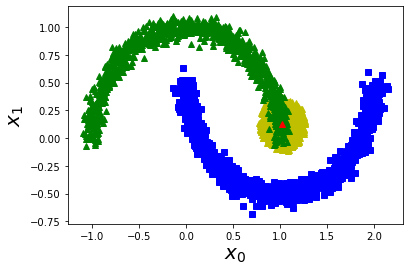

<function matplotlib.pyplot.show(close=None, block=None)>

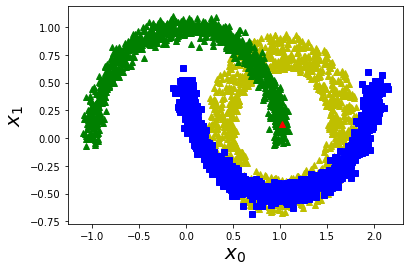

In [12]:
f = SL(X_test[0],0,0.5,1000)
plt.plot(f[:,0],f[:,1],'y^')
#couleur noir pour le point de test
plt.plot(X[:, 0][y==1], X[:, 1][y==1],'bs',label='classe 1')
plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'g^')
plt.plot(X_test[0,0],X_test[0,1],'r^')

# X contains two features, x1 and x2
plt.xlabel(r"$x_0$", fontsize=20)
plt.ylabel(r"$x_1$", fontsize=20)
plt.show()
plt.close

f = SL(X_test[0],0.7,0.9,1000)
plt.plot(f[:,0],f[:,1],'y^')
plt.plot(X[:, 0][y==1], X[:, 1][y==1],'bs')
plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'g^')
plt.plot(X_test[0,0],X_test[0,1],'r^')

# X contains two features, x1 and x2
plt.xlabel(r"$x_0$", fontsize=20)
plt.ylabel(r"$x_1$", fontsize=20)
plt.show

**Exemple de génération d'ennemie avant feature selection afin de verifier que le code est stable**

In [13]:
for i in range(50):
    res = algo_GSG(X[i],neigh,1,1000)
    print(i)
    print("X:", X[i], " Xpred:",neigh.predict(X[i].reshape(1,-1)), "\n enemy:", res, " enemypred:", neigh.predict(res.reshape(1,-1)))

0
X: [ 0.25896778 -0.11071323]  Xpred: [1] 
 enemy: [[0.55565671 0.15833351]]  enemypred: [0]
1
X: [0.05131397 0.09888339]  Xpred: [1] 
 enemy: [[-0.01058418  0.46808467]]  enemypred: [0]
2
X: [0.93684392 0.26588641]  Xpred: [0] 
 enemy: [[0.95463256 0.01469082]]  enemypred: [1]
3
X: [0.19669941 0.02349375]  Xpred: [1] 
 enemy: [[0.51645853 0.23623437]]  enemypred: [0]
4
X: [0.76895952 0.69690494]  Xpred: [0] 
 enemy: [[0.42129625 0.33758947]]  enemypred: [1]
5
X: [ 1.29529256 -0.51851427]  Xpred: [1] 
 enemy: [[1.16733732 0.09278029]]  enemypred: [0]
6
X: [0.95563721 0.362775  ]  Xpred: [0] 
 enemy: [[1.25200403 0.14935664]]  enemypred: [1]
7
X: [-0.20182423  0.94883132]  Xpred: [0] 
 enemy: [[-0.0443407   0.44118716]]  enemypred: [1]
8
X: [ 0.11443851 -0.02071197]  Xpred: [1] 
 enemy: [[0.49512892 0.27083073]]  enemypred: [0]
9
X: [-0.97019096  0.17397902]  Xpred: [0] 
 enemy: [[-0.47536249 -0.03267051]]  enemypred: [1]
10
X: [2.0580698  0.51097175]  Xpred: [1] 
 enemy: [[1.55140877 

**Exemple de génération d'ennemie avec feature selection afin de verifier que le code est stable**

In [14]:
for i in range(0,50):
    algo_GS(X_test[i],neigh,0.1,100)

**4. fonction permettant de visualiser les données, la frontière de décision, une donnée a expliquer ainsi que l’exemple contre-factuel qui lui est associé**

In [15]:
def affichage(x, ennemy, X_test, y_test, classifier):
    
    # Plot X
    plt.plot(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1],'bs')
    plt.plot(X_test[:, 0][y_test==0], X_test[:, 1][y_test==0], 'g^')

    # Plot x and son ennemy
    plt.plot(x[0], x[1], 'ro', label = 'x')
    plt.plot(ennemy[0], ennemy[1], 'r*', label = 'ennemy')

    # X contains two features, x1 and x2
    plt.xlabel(r"$x_0$", fontsize=20)
    plt.ylabel(r"$x_1$", fontsize=20)

    #frontière décision 
    h = .02  
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap='gray')

    # commentaires
    plt.legend()

    # plot.
    plt.show()

**Exemple**

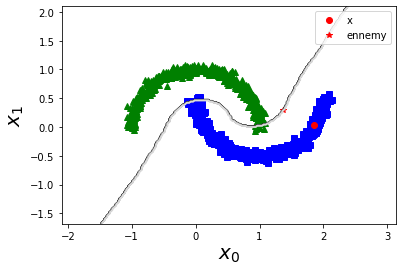

In [16]:
#hyperparamètres
classifier = neigh
eta = 0.5
n = 100
# on choisit un point au hasard dans le jeu de test
x = X_test[np.random.randint(low=0, high=len(X_test - 1))] 
# on applique l'algorithme growing spheres
ennemy = algo_GS(x,classifier,eta,n)
affichage(x, ennemy, X_test, y_test, neigh)

**5. Experimentations sur données artificielles**

In [17]:
def affichage_list(x, ennemy_list, X_test, y_test, classifier):
    
    # Plot the points of X except x
    plt.plot(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1],'bs')
    plt.plot(X_test[:, 0][y_test==0], X_test[:, 1][y_test==0], 'g^')

    # Plot x and its ennemies
    plt.plot(x[0], x[1], 'ro', label = 'x')
    for i in range(len(ennemy_list)-1):
        plt.plot(ennemy_list[i][0], ennemy_list[i][1], 'r*')
    plt.plot(ennemy_list[-1][0], ennemy_list[-1][1], 'r*', label = 'ennemies')
    
    #frontière décision 
    h = .02  
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap='gray')

    # X contains two features, x1 and x2
    plt.xlabel(r"$x_0$", fontsize=20)
    plt.ylabel(r"$x_1$", fontsize=20)

    # commentaires
    plt.legend()

    # Displaying the plot.
    plt.show()

**Observation d'une réalisation de l'algorithme sur differnt x et selon différent classifieur** 

classifieur: KNeighborsClassifier(n_neighbors=200)


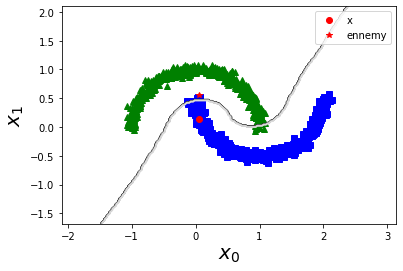

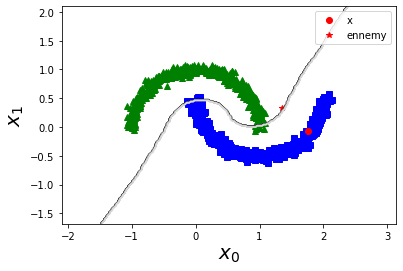

classifieur: RandomForestClassifier(n_estimators=200)


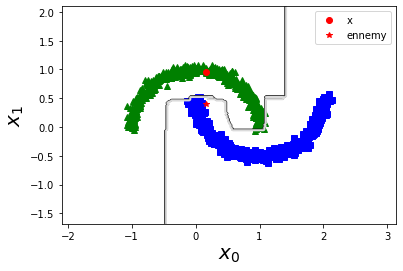

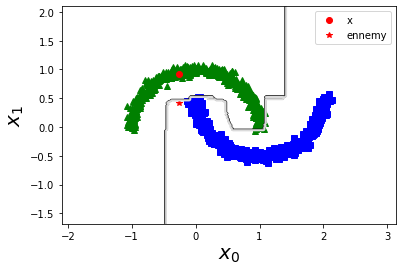

classifieur: SVC()


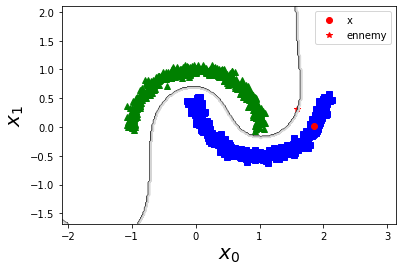

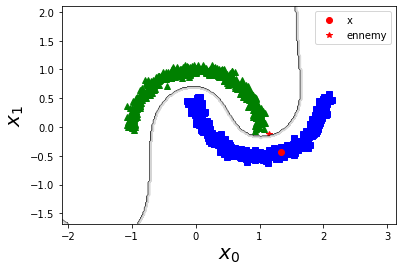

In [18]:
liste = [neigh, clf, sv]
for i in liste:
    print("classifieur:", i)
    # hyper parametre
    classifier = i
    eta = 0.5
    n = 100

    # On réalise 2 fois l'algorithme growing spheres et on plot les ennemies
    for j in range(2):
        x = X_test[np.random.randint(low=0, high=len(X_test - 1))] 
        ennemy=algo_GS(x,i,eta,n)
        affichage(x, ennemy, X_test, y_test, i)

**Observation de plusieurs réalisation de l'algorithme sur le meme point x**  
On peut voir que ceux ci se retrouvent bien tous dans la même zone proche de la frontière de décision peut importe le classifieur.  
Cependant avec la SVM il est plus compliqué d'obtenir un changement unique de dimension car la frontière est plus lisse. Avec les random forest, on a l'impression que l'algo rithme fonctionne mieux. 

classifieur: KNeighborsClassifier(n_neighbors=200)


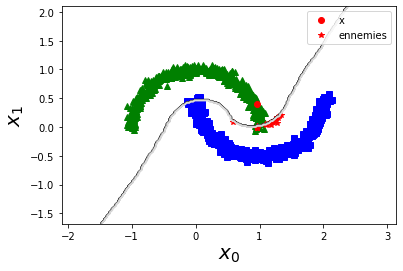

classifieur: RandomForestClassifier(n_estimators=200)


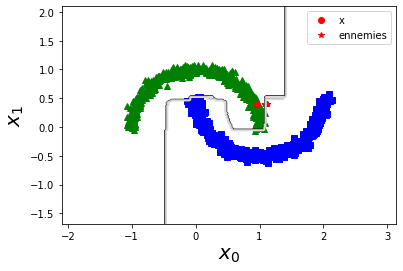

classifieur: SVC()


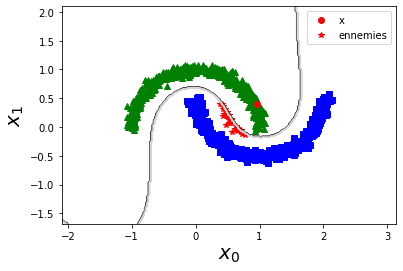

In [19]:
liste = [neigh, clf, sv]
x = X_test[np.random.randint(low=0, high=len(X_test - 1))] 
for i in liste:
    # hyper parametre
    classifier = i
    eta = 0.5
    n = 100

    # On réalise 10 fois l'algorithme growing spheres et on plot les ennemies
    ennemy_list = []
    for j in range(30):
        ennemy_list.append(algo_GS(x,i,eta,n))
    print("classifieur:", i)
    affichage_list(x, ennemy_list, X_test, y_test, i)

**modification de l'hyperparametra eta sur l'exemple d'une random forest**    
Il est responsable de la precision et qui va jouer sur la vitesse de convergence. On voit que plus le eta est petit ici plus il peut etre soumis au surapprentissage de la random forest 

classifieur: 0.01


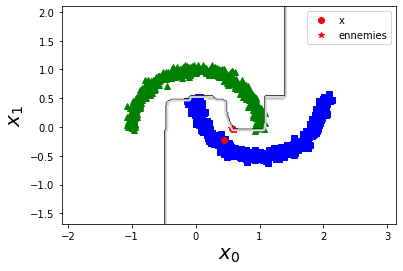

classifieur: 0.1


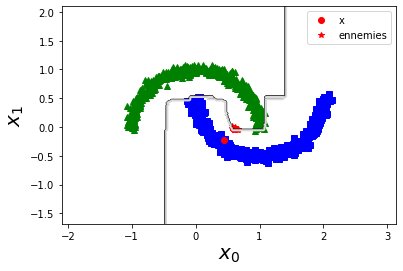

classifieur: 0.5


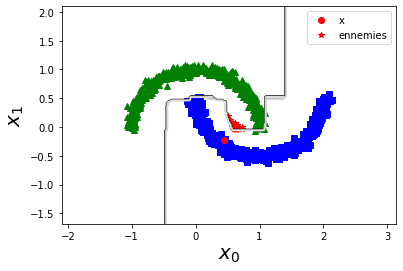

classifieur: 1


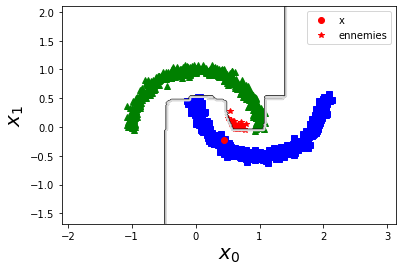

classifieur: 2


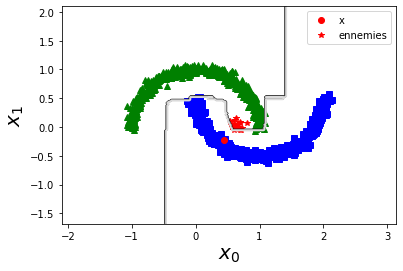

In [20]:
liste = [0.01,0.1,0.5,1,2]
x = X_test[np.random.randint(low=0, high=len(X_test - 1))] 
for i in liste:
    # hyper parametre
    classifier = clf
    eta = i
    n = 100

    # On réalise 10 fois l'algorithme growing spheres et on plot les ennemies
    ennemy_list = []
    for j in range(30):
        ennemy_list.append(algo_GS(x,clf,eta,n))
    print("classifieur:", i)
    affichage_list(x, ennemy_list, X_test, y_test, clf)

**Modification du nombre de points genéré Z**  
plus le nombre de points généré est petit, plus il y a de variance parmis les enemies et ils sont moins pertinents. Plus on genere de points, plus les enemies sont proches de X et de la frontière mais aussi algo plus long à tourner. 

classifieur: 1


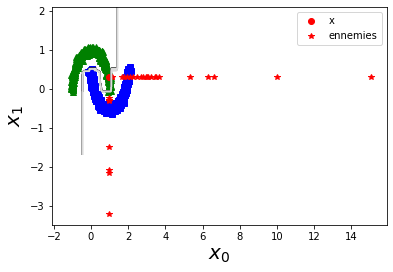

classifieur: 10


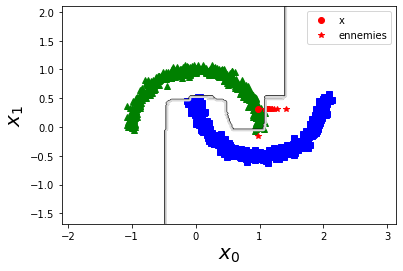

classifieur: 100


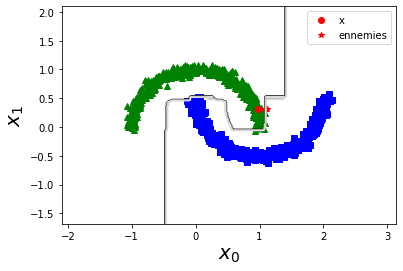

classifieur: 1000


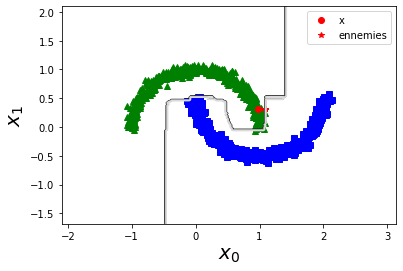

In [21]:
liste = [1,10,100,1000]
x = X_test[np.random.randint(low=0, high=len(X_test - 1))] 
for i in liste:
    # hyper parametre
    classifier = clf
    eta = 1
    n = i

    # On réalise 10 fois l'algorithme growing spheres et on plot les ennemies
    ennemy_list = []
    for j in range(30):
        ennemy_list.append(algo_GS(x,clf,eta,n))
    print("classifieur:", i)
    affichage_list(x, ennemy_list, X_test, y_test, clf)

**Modification paramètre nombre de voisins du knn et données bruitées**
plus le nombre de k est faible plus il y a du surapprentissage et plus l'algo growing sphere tombe dans des ilots d'explications qui ne paraissent pas pertinent.

classifieur: 1


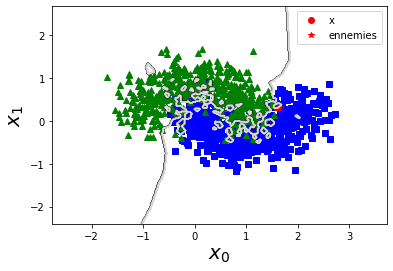

classifieur: 11


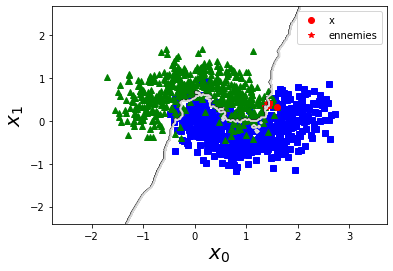

classifieur: 21


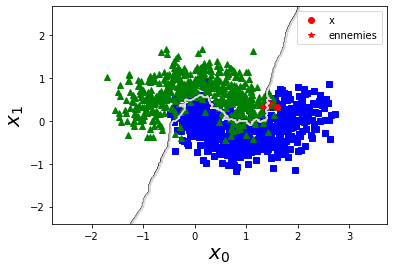

classifieur: 31


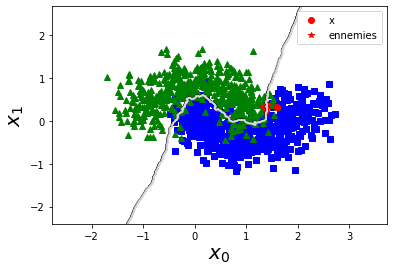

classifieur: 41


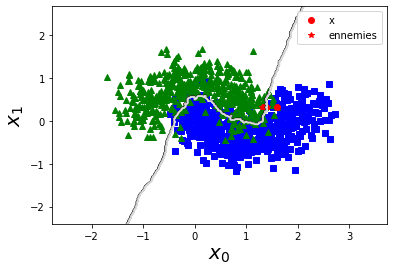

classifieur: 51


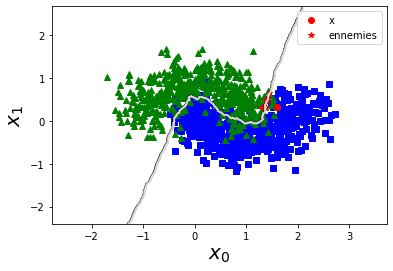

In [22]:
# On peut modifier noise pour avoir des nuages de points plus ou moins séparables
X,y = make_moons(n_samples=2000, shuffle=True, noise =0.3)
# decoupage en train et test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1000, train_size=1000, shuffle=True)

def knei(X_train,y_train, n):
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(X_train, y_train)
    return neigh

x = X_test[np.random.randint(low=0, high=len(X_test - 1))] 
for i in range(1,60,10):
    neigh = knei(X_train,y_train,i)
    eta = 0.5
    n = 100

    # On réalise 10 fois l'algorithme growing spheres et on plot les ennemies
    ennemy_list = []
    for j in range(30):
        ennemy_list.append(algo_GS(x,neigh,eta,n))
    print("classifieur:", i)
    affichage_list(x, ennemy_list, X_test, y_test, neigh)

**modification de parametre dans l'algorithme Random forest en changeant le nombre d'arbre et avec bruit**   
 On voit ici que l'algorythme semble stable mais peut etre sur apprentissage par exemple si on bruite plus les données

classifieur: 1


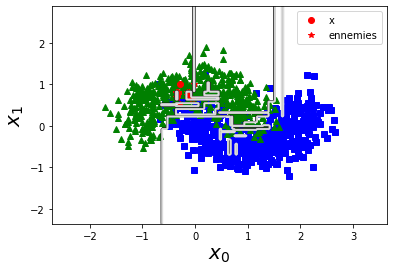

classifieur: 51


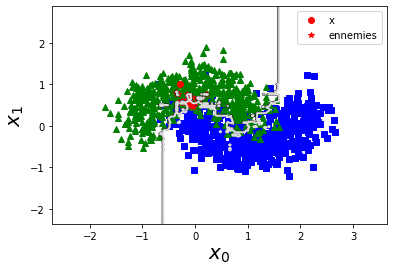

classifieur: 101


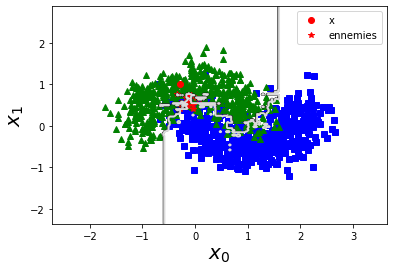

classifieur: 151


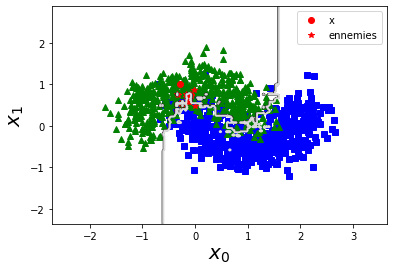

classifieur: 201


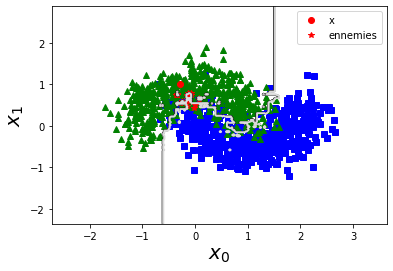

classifieur: 251


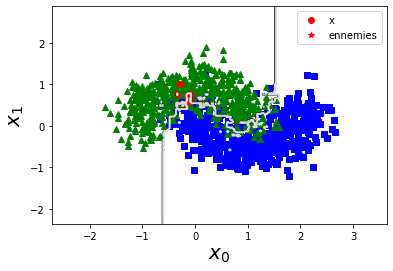

In [23]:
# On peut modifier noise pour avoir des nuages de points plus ou moins séparables
X,y = make_moons(n_samples=2000, shuffle=True, noise =0.3)
# decoupage en train et test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1000, train_size=1000, shuffle=True)

def RFC(X_train,y_train, n):
    clf = RandomForestClassifier(n_estimators=n)
    clf.fit(X_train, y_train)
    return clf

x = X_test[np.random.randint(low=0, high=len(X_test - 1))] 
for i in range(1,300,50):
    clf = RFC(X_train,y_train,i)
    eta = 0.5
    n = 100

    # On réalise 10 fois l'algorithme growing spheres et on plot les ennemies
    ennemy_list = []
    for j in range(30):
        ennemy_list.append(algo_GS(x,clf,eta,n))
    print("classifieur:", i)
    affichage_list(x, ennemy_list, X_test, y_test, clf)


**modification du kernel pour la SVM avec données bruitées**

classifieur: linear


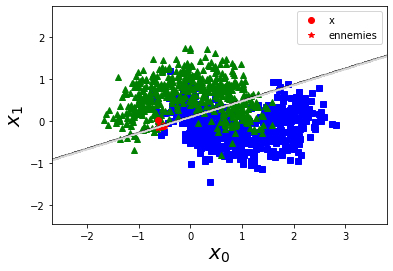

classifieur: poly


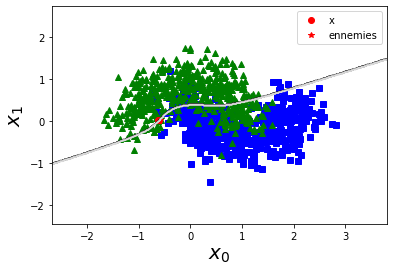

classifieur: rbf


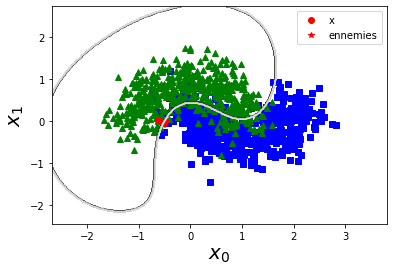

classifieur: sigmoid


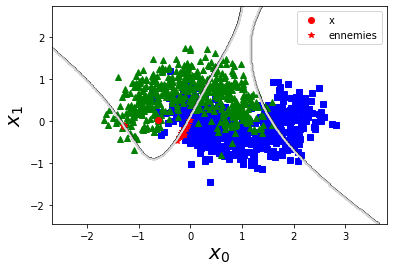

In [24]:
# On peut modifier noise pour avoir des nuages de points plus ou moins séparables
X,y = make_moons(n_samples=2000, shuffle=True, noise =0.3)
# decoupage en train et test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1000, train_size=1000, shuffle=True)

def singular(X_train,y_train, kernel):
    sv = SVC(kernel=kernel)
    sv.fit(X_train, y_train)
    return sv

x = X_test[np.random.randint(low=0, high=len(X_test - 1))] 
liste = ['linear', 'poly', 'rbf', 'sigmoid']
for i in liste:
    sv = singular(X_train,y_train,i)
    eta = 0.5
    n = 100

    # On réalise 10 fois l'algorithme growing spheres et on plot les ennemies
    ennemy_list = []
    for j in range(30):
        ennemy_list.append(algo_GS(x,sv,eta,n))
    print("classifieur:", i)
    affichage_list(x, ennemy_list, X_test, y_test, sv)

In [25]:
# charge les données
data = load_breast_cancer()
X, y = load_breast_cancer(return_X_y=True)
# faire un split train test
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size =0.7, random_state=0)
#on fait par exemple une SVM
clf = SVC()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print("accuracy",accuracy(y_test,pred))

for i in range(5):
    print(i)
    enem = algo_GS(X_test[i],clf,0.01,10)
    indice = np.argwhere(X_test[i] != enem)
    print("features à modifier pour changer de classe: \n", data.feature_names[indice])
    
    # Pour different X, on print les features modifiées lors du choix de e_best
    # on print les features qui sont différentes entre X et e_best 
    # et donc les variables à modifier pour changer la prédiction

accuracy 0.9239766081871345
0
features à modifier pour changer de classe: 
 [['worst area']]
1
features à modifier pour changer de classe: 
 [['mean radius']
 ['mean texture']
 ['mean area']
 ['mean compactness']
 ['mean fractal dimension']
 ['smoothness error']
 ['fractal dimension error']
 ['worst radius']
 ['worst texture']
 ['worst area']
 ['worst compactness']
 ['worst concavity']
 ['worst symmetry']]
2
features à modifier pour changer de classe: 
 [['worst area']]
3
features à modifier pour changer de classe: 
 [['worst area']]
4
features à modifier pour changer de classe: 
 [['mean concavity']
 ['worst area']
 ['worst symmetry']]
